In [41]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))
#sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/'))
#sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/ibm/'))

In [42]:
import numpy as np

import qiskit
provider = qiskit.IBMQ.load_account()
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import QAOA
from shared.QiskitMaxcut import *
from ibm.ibm_parameters import *
from shared.gem.gem_instance import GEMInstance
from shared.gem.gem_quantum_instance import GEMQuantumInstance
from matplotlib import pyplot as plt
%matplotlib inline

ibmqfactory.load_account:WARNING:2021-09-29 15:00:22,944: Credentials are already in use. The existing account in the session will be replaced.


In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


graph_05_06_02_w


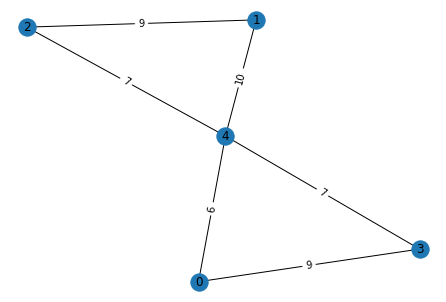

In [44]:
graph = generate_butterfly_graph(with_weights=True)
max_cut = Maxcut(graph)
max_cut_qubo = max_cut.to_qubo()
print(graph.name)
max_cut.draw()

In [66]:
step_size = 0.1
a_gamma = np.arange(0, np.pi, step_size)
b_beta = np.arange(0, np.pi, step_size)

In [67]:
a_gamma, b_beta = np.meshgrid(a_gamma, b_beta)
len(a_gamma)

32

In [68]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i,j,w in graph.edges.data('weight'):
        if x[i] != x[j]:
            obj -= w
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

In [69]:
import qiskit
from qiskit import Aer
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.models import BackendConfiguration
from helpers.config import *
import pickle 
from shared.gem.gem_quantum_instance import GEMQuantumInstance

#
# Quantum Instance 
#
DEFAULT_QASM_SIMULATOR = "qasm_simulator"
NOISE_BACKEND = "ibmq_toronto"

# Noise 
noise_model = None 
coupling_map = None
basis_gates = None

# create instance depending on config 
def create_quantum_instance():
    from helpers.config import BACKEND

    quantum_instance = None
    
    if BACKEND.value == Backend.Simulator.value:
        return GEMQuantumInstance(
                                        backend=Aer.get_backend(DEFAULT_QASM_SIMULATOR),
                                        shots=SHOTS,
                                        )
    
    if BACKEND.value == Backend.Simulator_Noise_Model.value:
        quantum_instance = _create_simulator_with_noise_quantum_instance()
        print("create noise")
    elif BACKEND.value == Backend.IBMQ_Toronto.value:
        raise Exception("Quantum Instance with Toronto not implemented!")
    else: 
        raise Exception(f"Quantum Instance not instanciated! {BACKEND.value}")
    
    return quantum_instance


def _init_noise_model_parameters():
    global noise_model, coupling_map, basis_gates
    if noise_model is None or coupling_map is None or basis_gates is None:
        noise_model_filename = f"helpers/ibmq_toronto_noise_model_dict.pkl"
        noise_model_dict = load_from_pickle(noise_model_filename)
        noise_model = NoiseModel.from_dict(noise_model_dict)
        basis_gates = noise_model.basis_gates
        
        noise_backend_configuration_filename = f"helpers/ibmq_toronto_noise_backend_configuation_dict.pkl"
        noise_backend_configuration_dict = load_from_pickle(noise_backend_configuration_filename)
        noise_backend_configuration = BackendConfiguration.from_dict(noise_backend_configuration_dict)
        coupling_map = noise_backend_configuration.coupling_map
        

def _create_simulator_with_noise_quantum_instance():
    
    _init_noise_model_parameters()
    
    quantum_instance = GEMQuantumInstance(
                                        backend=Aer.get_backend(DEFAULT_QASM_SIMULATOR),
                                        shots=SHOTS,
                                        noise_model=noise_model,
                                        coupling_map=coupling_map,
                                        basis_gates=basis_gates,
                                        )
    return quantum_instance


def load_from_pickle(name):
    with open(name, 'rb') as f:
        return pickle.load(f)


In [70]:
#quantum_instance = GEMQuantumInstance(
#                    #backend=Aer.get_backend(DEFAULT_QASM_SIMULATOR),
#                    backend=provider.get_backend('ibmq_sydney'),
#                    shots=SHOTS)


quantum_instance = create_quantum_instance()

qaoa = QAOA(
            optimizer=COBYLA(maxiter=0),
            quantum_instance=quantum_instance,
            reps=1
            )

op, offset = max_cut_qubo.to_ising()

create noise


In [71]:
def create_cirucit(gamma,beta):
    circuits = qaoa.construct_circuit([gamma,beta], operator=op)
    circuit = circuits[0]
    circuit.measure_all()
    return circuit

In [72]:
gem_instance = GEMInstance()

In [73]:
first_circuit = create_cirucit(0.5,0.5)

In [74]:
mg = gem_instance.get_gem_matrix(first_circuit, quantum_instance)

In [75]:
quantum_instance.MG = mg
mg

array([[7.29980469e-01, 7.56835938e-02, 9.22851562e-02, ...,
        9.76562500e-04, 4.39453125e-03, 2.44140625e-03],
       [3.17382812e-02, 6.66992188e-01, 1.36718750e-02, ...,
        3.41796875e-03, 2.44140625e-03, 2.92968750e-03],
       [4.58984375e-02, 5.37109375e-03, 6.07910156e-01, ...,
        1.95312500e-03, 4.88281250e-04, 0.00000000e+00],
       ...,
       [4.88281250e-04, 0.00000000e+00, 1.95312500e-03, ...,
        6.31835938e-01, 4.88281250e-03, 4.19921875e-02],
       [3.41796875e-03, 1.46484375e-03, 6.34765625e-03, ...,
        8.30078125e-03, 6.47460938e-01, 7.86132812e-02],
       [9.76562500e-04, 1.95312500e-03, 1.46484375e-03, ...,
        2.73437500e-02, 2.73437500e-02, 5.93750000e-01]])

In [76]:
landscape = np.zeros(a_gamma.shape)

for i in range(0, len(landscape)):
    circuits = []
    for j in range(0, len(landscape)):
        # create circuits for entire row 
        circuit = create_cirucit(a_gamma[i][j], b_beta[i][j])
        job = quantum_instance.execute([circuit])
        count = job.get_counts()
        #print(job)
        #print(count)
        mean = compute_expectation(count, graph)
        landscape[i,j] = mean
        #m =0
       # for n in count.values():
       #     m += n
       # print(m)
       # break
        
    #break
        #circuits.append(circuit)
    
    # create one job with circuits 
    job_name = f"{graph.name}_gem_row_{i}"
    #job = quantum_instance.execute(circuits)
    #job.update_name(job_name)
    print(job_name)
    #print(job)
    
    # add results to landscape 
    #k = 0
    #for count in job.get_counts():
    #    mean = compute_expectation(count, graph)
    #    landscape[i,k] = mean
    #    k += 1

graph_05_06_02_w_gem_row_0
graph_05_06_02_w_gem_row_1
graph_05_06_02_w_gem_row_2
graph_05_06_02_w_gem_row_3
graph_05_06_02_w_gem_row_4
graph_05_06_02_w_gem_row_5
graph_05_06_02_w_gem_row_6
graph_05_06_02_w_gem_row_7
graph_05_06_02_w_gem_row_8
graph_05_06_02_w_gem_row_9
graph_05_06_02_w_gem_row_10
graph_05_06_02_w_gem_row_11
graph_05_06_02_w_gem_row_12
graph_05_06_02_w_gem_row_13
graph_05_06_02_w_gem_row_14
graph_05_06_02_w_gem_row_15
graph_05_06_02_w_gem_row_16
graph_05_06_02_w_gem_row_17
graph_05_06_02_w_gem_row_18
graph_05_06_02_w_gem_row_19
graph_05_06_02_w_gem_row_20
graph_05_06_02_w_gem_row_21
graph_05_06_02_w_gem_row_22
graph_05_06_02_w_gem_row_23
graph_05_06_02_w_gem_row_24
graph_05_06_02_w_gem_row_25
graph_05_06_02_w_gem_row_26
graph_05_06_02_w_gem_row_27
graph_05_06_02_w_gem_row_28
graph_05_06_02_w_gem_row_29
graph_05_06_02_w_gem_row_30
graph_05_06_02_w_gem_row_31


[[-24.52761571 -24.17837705 -23.3899412  ... -23.55882671 -23.89485838
  -24.40163798]
 [-23.39084954 -21.26867061 -22.99277742 ... -24.39690197 -23.74468017
  -23.76362603]
 [-24.20156712 -19.03321059 -22.17266416 ... -25.70723155 -23.01145709
  -23.48223469]
 ...
 [-23.47949154 -27.74819238 -23.14888823 ... -24.59967108 -25.39696075
  -23.62123558]
 [-23.81695277 -27.5129413  -23.45616284 ... -23.72133801 -24.05986432
  -23.59290006]
 [-23.4928196  -24.83291261 -23.08427776 ... -23.66286533 -23.18011369
  -23.36481745]]


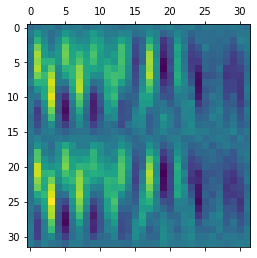

In [77]:
print(landscape)
plt.matshow(landscape)
plt.show()

In [78]:
# Mean of landscape
np.mean(landscape)

-23.38839398178912

In [79]:
# Minimium 
np.min(landscape)

-31.277920087760318

In [80]:
# Display Coordinates of Minimum 
np.unravel_index(np.argmin(landscape), landscape.shape)

(21, 19)

In [81]:
# Gamma and beta value of Minimium
gamma, beta = np.unravel_index(np.argmin(landscape), landscape.shape)
opt_gamma = gamma * step_size
opt_beta = beta * step_size
print(f"Opt.Gamma: {opt_gamma}, Opt.Beta: {opt_beta}")

Opt.Gamma: 2.1, Opt.Beta: 1.9000000000000001


In [82]:
# Save result matrix 
with open('landscape_toronto_noise_model_butterfly_weights_gem_results.npy', 'wb') as f:
    np.save(f, landscape)

In [83]:
import plotly.graph_objects as go

In [86]:
# Plot landscape in 3D 
a_gamma = np.arange(0, np.pi, step_size)
b_beta = np.arange(0, np.pi, step_size)
fig = go.Figure(data=go.Surface(z=landscape, x=a_gamma, y=b_beta))

fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor='limegreen', project_z=True))


fig.update_layout(title="QAOA with General Error Mitigation - MaxCut-Landscape", scene=dict(
    xaxis_title="γ",
    yaxis_title="β",
    zaxis_title="F(γ,β)"
))

In [85]:
# Plot Heatmap 
fig = go.Figure(data=go.Heatmap(z=landscape, x=b_beta, y=a_gamma, type = 'heatmap', colorscale = 'viridis'))

# Update Layout
fig.update_layout(title="F(γ,β)", width=700, height=700, yaxis_title="β", xaxis_title="γ")

# Display Global Minimium 
fig.add_trace(
    go.Scatter(mode="markers", x=[opt_beta], y=[opt_gamma], marker_symbol=[204], text = [landscape[gamma,beta]],
                   marker_color="red",  hovertemplate="x: %{x}<br>y: %{y}<br> z: %{text:.2f}<extra></extra>", 
                   marker_line_width=1, marker_size=16))

In [65]:
# Display Optimizer Results

# Display path 
#fig.add_trace(
#    go.Scatter(mode="lines", x=gammas, y=betas, marker_symbol=[200],
#                   marker_color="white", marker_line_width=1, marker_size=8)
#)

# Display start point
#fig.add_trace(
#    go.Scatter(mode="markers", x=[gammas[0]], y=[betas[0]], marker_symbol=[204],
#                   marker_color="gray", 
#                   marker_line_width=1, marker_size=16))

# Display end point
#fig.add_trace(
#    go.Scatter(mode="markers", x=[gammas[-1]], y=[betas[-1]], marker_symbol=[204],
#                   marker_color="green", 
#                   marker_line_width=1, marker_size=16))



In [26]:
# Plot Optimizer History
#fig = go.Figure(data=go.Scatter(x=counts, y=values))
#fig.update_layout(xaxis_title="Evaluation Counts", yaxis_title="Evaluated Mean", title="Optimizer")
#fig.show()